# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
nltk.download(['punkt', 'wordnet','stopwords'])

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /home/sa_aramco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sa_aramco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sa_aramco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# find number of columns and rows
df.shape[0]

45993

In [4]:
# median 
df.groupby('email')['article_id'].count().median()

3.0

In [5]:
# max
df.groupby('email')['article_id'].count().max()

364

In [6]:
# Calculate the median and maximum number of user-article interactions
median_val = df.groupby('email')['article_id'].count().median()
max_views_by_user = df.groupby('email')['article_id'].count().max()

In [7]:
# Calculate the number of interactions per user
user_interacts = df.groupby('email')['article_id'].count()
user_interacts

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

In [8]:
# summary stats
user_interacts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

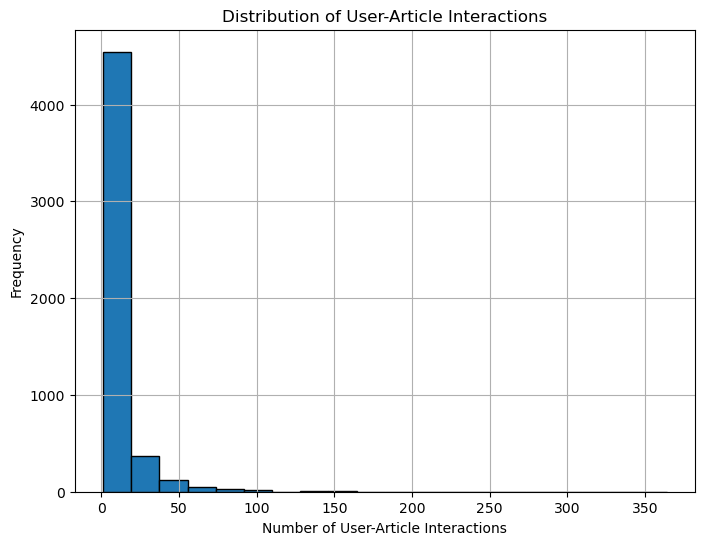

In [10]:
# Plot a histogram of user-article interactions
plt.figure(figsize=(8, 6))
user_interacts.plot(kind='hist', bins=20, edgecolor='black')
plt.title('Distribution of User-Article Interactions')
plt.xlabel('Number of User-Article Interactions')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles
df_content.duplicated("article_id").sum()

5

In [12]:
ids = df_content['article_id']

In [13]:
# explore duplicate articles
df_content[ids.isin(ids[ids.duplicated()])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [14]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates("article_id", keep="first")
df_content

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles =  df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [16]:
unique_articles

714

In [17]:
total_articles

1051

In [18]:
unique_users

5148

In [19]:
user_article_interactions

45993

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [20]:
# Find the most viewed article IDs
most_viewed_articles = df['article_id'].value_counts().head(2)
most_viewed_articles

article_id
1429.0    937
1330.0    927
Name: count, dtype: int64

In [24]:
# Find the most viewed article ID and its view count
most_viewed_article_id = str(df.article_id.value_counts().index[0])
max_views = df['article_id'].value_counts().iloc[0]

In [25]:
most_viewed_article_id

'1429.0'

In [26]:
max_views

937

In [27]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [28]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [29]:
def get_top_articles(n, df=df):
    '''
    Get the top 'n' article titles based on user interactions.

    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) the DataFrame containing user interactions

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    '''

    # Get the most frequently occurring article titles
    top_article_titles = df['title'].value_counts().index.tolist()[:n]
    top_article_titles = [str(title) for title in top_article_titles]
    
    return top_article_titles

def get_top_article_ids(n, df=df):
    '''
    Get the top 'n' article IDs based on user interactions.

    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) the DataFrame containing user interactions

    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article IDs
    '''

    # Get the most frequently occurring article IDs
    top_article_ids = df['article_id'].value_counts().index.tolist()[:n]
    top_article_ids = [str(article_id) for article_id in top_article_ids]

    return top_article_ids

In [30]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [31]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [34]:
def create_user_item_matrix(df):
    '''
    Create a user-item interaction matrix with 1's and 0's.

    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user-item interaction matrix 
    
    Description:
    Returns a matrix with user IDs as rows and article IDs as columns.
    Contains 1 where a user interacted with an article, and 0 otherwise.
    '''
    # Create a new dataframe based on counts
    df_count = df.groupby(['user_id', 'article_id']).count().reset_index()

    # Pivot the dataframe so that users are on rows and articles are on columns
    user_item = df_count.pivot_table(values='title', index='user_id', columns='article_id')

    # Replace NaN values with 0
    user_item.fillna(0, inplace=True)

    # Convert entries to 1 if they are greater than 0, otherwise keep as 0
    user_item = user_item.astype(bool).astype(int)

    return user_item

user_item = create_user_item_matrix(df)


In [35]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [36]:
def find_similar_users(user_id, user_item=user_item):
    '''
    Find similar users for a given user based on the dot product of their interaction patterns.

    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product of their interaction patterns.
    Returns an ordered list of user IDs where the most similar users are listed first.
    '''
    # Compute the dot product of user-item interaction matrices
    dot_prod_users = user_item.dot(user_item.T)
    
    # Sort users by similarity
    similar_users = dot_prod_users.loc[user_id].sort_values(ascending=False)
    
    # Create a list of most similar user IDs
    most_similar_users = similar_users.index.tolist()
    
    # Remove the input user's ID from the list
    most_similar_users.remove(user_id)
       
    return most_similar_users


In [37]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 4201, 46, 49]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [38]:
def get_article_names(article_ids, df=df):
    '''
    Get the article names associated with a list of article IDs.

    INPUT:
    article_ids - (list) a list of article IDs
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article IDs 
    '''
    article_names = []
    
    for idx in article_ids:
        article_names.append(df[df['article_id'] == float(idx)]['title'].max())
    
    return article_names

def get_user_articles(user_id, user_item=user_item):
    '''
    Get the article IDs and names that have been seen by a user.

    INPUT:
    user_id - (int) a user ID
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article IDs seen by the user
    article_names - (list) a list of article names associated with the list of article IDs 
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str)
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names

def user_user_recs(user_id, m=10):
    '''
    Generate user-based recommendations for a given user.

    INPUT:
    user_id - (int) a user ID
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Continues this process until m recommendations are found
    '''
    recs = []  # Recommendations to be made
    
    user_articles_seen = set(get_user_articles(user_id)[0])  # Articles seen by our user
    closest_users = find_similar_users(user_id)  # Users closest to our user
    
    for other_user in closest_users:
        other_articles_seen = set(get_user_articles(other_user)[0])  # Articles seen by others like our user
        new_recs = other_articles_seen - user_articles_seen  # Find those not seen by user
        recs.extend(new_recs)
        
        if len(recs) >= m:
            break
    
    recs = recs[:m]  # Limit the number of recommendations
    return recs  # Return recommendations for this user_id


In [39]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 25, 2017)',
 'apache spark lab, part 3: machine learning',
 'this week in data science (may 2, 2017)',
 'the power of machine learning in spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'recent trends in recommender systems',
 'this week in data science (may 30, 2017)',
 '54174    detect potentially malfunctioning sensors in r...\nName: title, dtype: object',
 'overlapping co-cluster recommendation algorithm (ocular)',
 'higher-order logistic regression for large datasets']

In [40]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [41]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    Get a dataframe of similar users sorted by similarity and number of interactions.

    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Description:
    Sorts the neighbors_df by similarity and number of interactions in descending order.
    '''
    # Compute user similarities using dot product
    user_similarities = user_item.dot(user_item.loc[user_id])
    
    # Create a dataframe of neighbors and their similarities
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_item.index,
        'similarity': user_similarities,
    })
    
    # Add the number of interactions per neighbor
    neighbors_df['num_interactions'] = df.groupby('user_id')['article_id'].count().loc[neighbors_df['neighbor_id']]
    
    # Sort by similarity and number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    neighbors_df = neighbors_df.reset_index(drop=True)
    
    # Remove the input user from the list of neighbors
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    Generate user-based recommendations for a given user considering neighbors' interactions.

    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the neighbors based on their interactions and similarity to the input user_id.
    For each neighbor - finds articles the user hasn't seen before and provides them as recs.
    Continues this process until m recommendations are found.
    '''
    recs = set()  # Recommendations to be made
    
    user_articles_seen = set(get_user_articles(user_id)[0])  # Articles seen by our user
    closest_neighbors = get_top_sorted_users(user_id)['neighbor_id']  # Neighbors sorted by interactions and similarity
    
    for neighbor in closest_neighbors:
        neighbor_articles_seen = set(get_user_articles(neighbor)[0])  # Articles seen by the neighbor
        new_recs = neighbor_articles_seen - user_articles_seen  # Find those not seen by user
        recs.update(new_recs)
        
        if len(recs) >= m:
            break
    
    recs = list(recs)[:m]  # Limit the number of recommendations
    rec_names = get_article_names(recs)
    
    return recs, rec_names


In [42]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1364.0', '1162.0', '981.0', '1172.0', '1151.0', '681.0', '761.0', '1346.0', '1357.0', '1411.0']

The top 10 recommendations for user 20 are the following article names:
['predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'super fast string matching in python', 'apache spark lab, part 3: machine learning', 'airbnb data for analytics: venice listings', 'real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)', 'variational auto-encoder for "frey faces" using keras', 'military expenditure as % of gdp by country', 'overlapping co-cluster recommendation algorithm (ocular)', 'uci: white wine quality']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [45]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

In [46]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [47]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df)



In [48]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [49]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [50]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [51]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [52]:
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

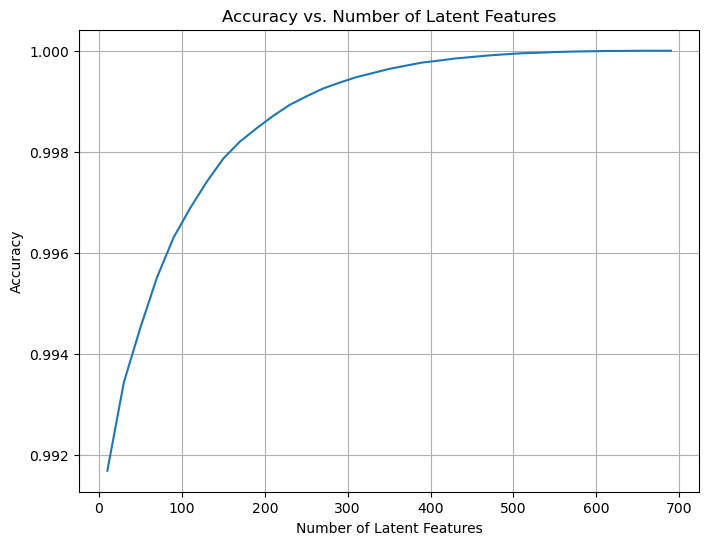

In [54]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs = []

for k in num_latent_feats:
    # Restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # Take dot product to estimate user-item interactions
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Compute error for each prediction compared to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # Total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
# Calculate accuracy as (1 - normalized sum of errors)
accuracy = 1 - np.array(sum_errs) / user_item_matrix.size

# Plot accuracy against number of latent features
plt.figure(figsize=(8, 6))
plt.plot(num_latent_feats, accuracy)
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.grid(True)
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [55]:
# Split the dataframe into training and testing sets
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    Create user-item matrices and related data for training and testing dataframes.
    
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    Description:
    - Creates user-item matrices for both training and testing data.
    - Extracts test user IDs and article IDs.
    '''
    # Create user-item matrices for training and testing data
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Extract test user IDs and article IDs
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

# Create user-item matrices and related data for training and testing data
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


In [56]:
test_idx # 682 users in test set

Index([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801,
       ...
       5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
      dtype='int64', name='user_id', length=682)

In [57]:
train_idx = user_item_train.index # 4487 users in training set
train_idx 

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487],
      dtype='int64', name='user_id', length=4487)

In [58]:
test_idx.difference(train_idx) # of 682 users in test set, only 20 of them are in training set

Index([4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497,
       ...
       5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
      dtype='int64', name='user_id', length=662)

In [59]:
test_arts #574 movies in test set

Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,   16.0,
         18.0,
       ...
       1432.0, 1433.0, 1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0,
       1443.0],
      dtype='float64', name='article_id', length=574)

In [60]:
train_arts = user_item_train.columns #714 movies in train set
train_arts

Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,   16.0,
         18.0,
       ...
       1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0, 1443.0,
       1444.0],
      dtype='float64', name='article_id', length=714)

In [61]:
test_arts.difference(train_arts) # all articles in test set are in training set too

Index([], dtype='float64', name='article_id')

In [67]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many articles can we make predictions for in the test set?': b,# letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [68]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [69]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

In [70]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs_train = []
sum_errs_test = []

# Indices for rows and columns that match the test set
row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)

# Extract the corresponding rows and columns from train matrix for decomposition
u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

# Find users in the test set that are also present in the training set
users_can_predict = np.intersect1d(list(user_item_train.index), list(user_item_test.index))

for k in num_latent_feats:
    # Restructure matrices with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # Calculate predicted user-item interactions for both train and test sets
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # Compute error for each prediction compared to actual value for both train and test sets
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[users_can_predict, :], user_item_test_preds)
    
    # Calculate total errors and keep track of them for both train and test sets
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)


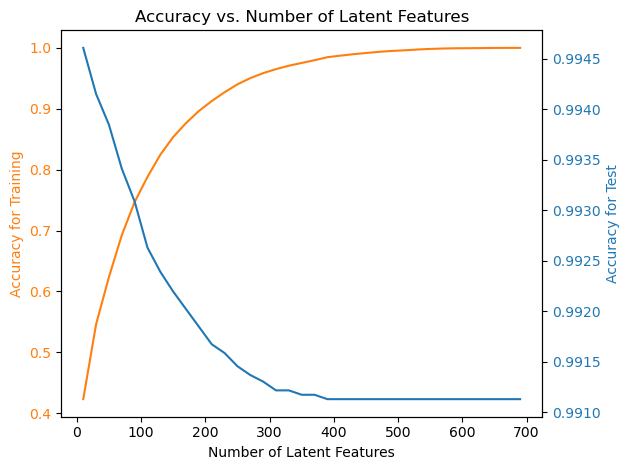

In [71]:
# Create a figure with two y-axes
fig, ax1 = plt.subplots()

# Plotting training accuracy on the first y-axis
color = 'tab:orange'
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Accuracy for Training', color=color)
ax1.plot(num_latent_feats, 1 - np.array(sum_errs_train) / df.shape[0], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Accuracy vs. Number of Latent Features')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plotting test accuracy on the second y-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy for Test', color=color)
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_test) / df.shape[0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adjust layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

From the analysis above, we observe an interesting pattern: the accuracy for the training data tends to increase with a higher number of latent features, while conversely, the accuracy for the test data decreases. This phenomenon is likely attributed to overfitting—the data fits too closely to the training set, resulting in poorer generalization to unseen data in the test set. Therefore, it's important to strike a balance and keep the number of latent features reasonably low to prevent overfitting.

It's worth noting that in this scenario, we can only provide meaningful recommendations for the 20 users present in both the training and test datasets. Our user-item interaction matrix is quite sparse, which contributes to the high accuracy of the test data (exceeding 99%). This high accuracy is partly due to the limited scope of users.

An interesting avenue for exploration would involve examining the results with a larger user base shared between the training and test datasets. At approximately 80 latent features, we identify a pivotal point where the accuracy for the test data begins to decline. This suggests that around 80 features might be an optimal choice, as it strikes a balance between improving training accuracy and maintaining reasonable test accuracy.

To validate the real-world performance of our recommendation engine, conducting an A/B test on new users could be a valuable step, particularly in addressing the 'cold start' problem. One group of users could receive recommendations generated by our engine, while another group is recommended only the most popular articles. By comparing the click-through rates between the two groups, we can effectively assess whether our recommendation engine leads to a significant increase in user engagement. A substantial increase in clicks among the group exposed to our recommendation engine would provide strong evidence of its efficacy and support its deployment.